<a href="https://colab.research.google.com/github/ericodle/J_PlanktoNET/blob/main/exploratory_notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I tried again with ResNet50.

This time, I abandoned the unsupervised learning approach and did a simple one-hot fine tune. Just two epochs, standard hyperparameters.
Unsupervised learning on ResNet50 was too much for Colab's free GPU.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture
class FineTunedModel(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Hyperparameters
num_classes = 10
learning_rate = 0.001
batch_size = 128
num_epochs = 2

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = FineTunedModel(num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


100%|██████████| 9912422/9912422 [00:00<00:00, 372735931.26it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 63091507.20it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 143450486.33it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4430355.53it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 309MB/s]


Epoch [1/2], Step [100/469], Loss: 0.1603
Epoch [1/2], Step [200/469], Loss: 0.0734
Epoch [1/2], Step [300/469], Loss: 0.0438
Epoch [1/2], Step [400/469], Loss: 0.0385
Epoch [2/2], Step [100/469], Loss: 0.0847
Epoch [2/2], Step [200/469], Loss: 0.0330
Epoch [2/2], Step [300/469], Loss: 0.0033
Epoch [2/2], Step [400/469], Loss: 0.0050
Test Accuracy: 99.02%


Here I'm using the MNIST dataset, which as you will see later, is a big collection of hand-written numbers "0-9" one-hot labeled accordingly.

The logic behind this approach was "Get it working with MNIST first, then our photos later."

In [4]:
model.eval()
model.to(device)

FineTunedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

Now that the model is fine-tuned, I want to generate paired lists called "embeddings" and "labels".

In [5]:
embeddings = []
labels = []

I send a subset of MNIST previously divided for train loop evaluation (test_loader) through the model again, but this time I want to extract the embeddings.

In [6]:
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)

        # Generate embeddings
        embeddings_batch = model(images)

        # Append embeddings and labels to the lists
        embeddings.append(embeddings_batch)
        labels.append(targets)


In [7]:
embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)

In [10]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To confirm that everything worked properly, I conduct principle component analysis on the embedings to crunch the data down to 2 dimensions, then I make a colorful dot plot to show our model's ability to properly cluster (distinguish) the images.

<ipython-input-16-599f665f1e68>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_classes)


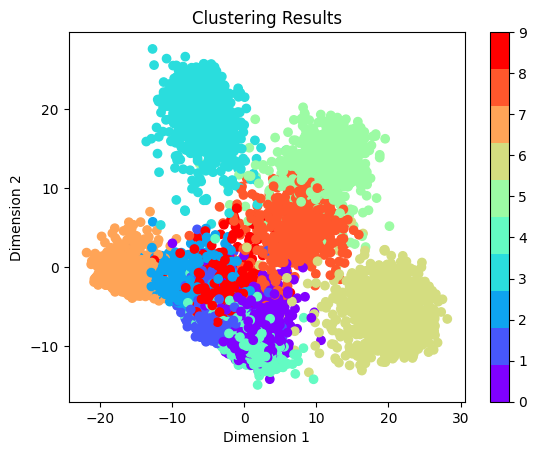

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA on the embeddings
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# Move labels to CPU
labels = labels.cpu().numpy()

# Create a color map for the clusters
cmap = plt.cm.get_cmap('rainbow', num_classes)

# Plot the scatter plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap=cmap)
plt.colorbar()

# Set the plot title and axis labels
plt.title('Clustering Results')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Show the plot
plt.show()

For the next test, I ran K Means Clustering on the extracted embeddings followed by a visualization of how well the images grouped with their inferred clusters.

In [18]:
from sklearn.cluster import KMeans

# Create a K-means clustering object
kmeans = KMeans(n_clusters=num_classes)

# Fit the embeddings to the K-means model
kmeans.fit(embeddings.cpu().numpy())

# Get the predicted cluster labels
predicted_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


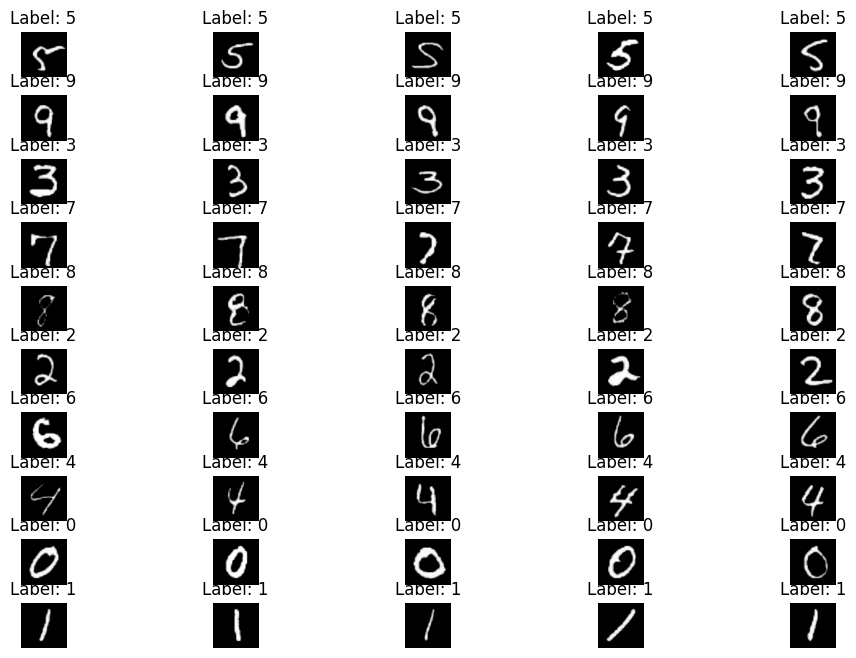

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Select a subset of images to display per cluster
subset_size = 5  # Number of images to display per cluster

# Create a figure to display the images
fig, axes = plt.subplots(num_classes, subset_size, figsize=(12, 8))

# Iterate over each cluster
for cluster_label in range(num_classes):
    cluster_indices = np.where(predicted_labels == cluster_label)[0]
    selected_indices = np.random.choice(cluster_indices, size=subset_size, replace=False)

    # Iterate over the selected indices and display the images
    for i, idx in enumerate(selected_indices):
        image = test_dataset[idx][0]  # Get the image tensor
        label = test_dataset[idx][1]  # Get the true label

        # Convert the image tensor to a NumPy array
        image = image.permute(1, 2, 0).numpy()

        # Plot the image
        axes[cluster_label, i].imshow(image, cmap='gray')
        axes[cluster_label, i].axis('off')
        axes[cluster_label, i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the figure
plt.show()


Our clustering approach is showing promise!

Can we cluster hierarchically and then visualize the output?

I bet we can.

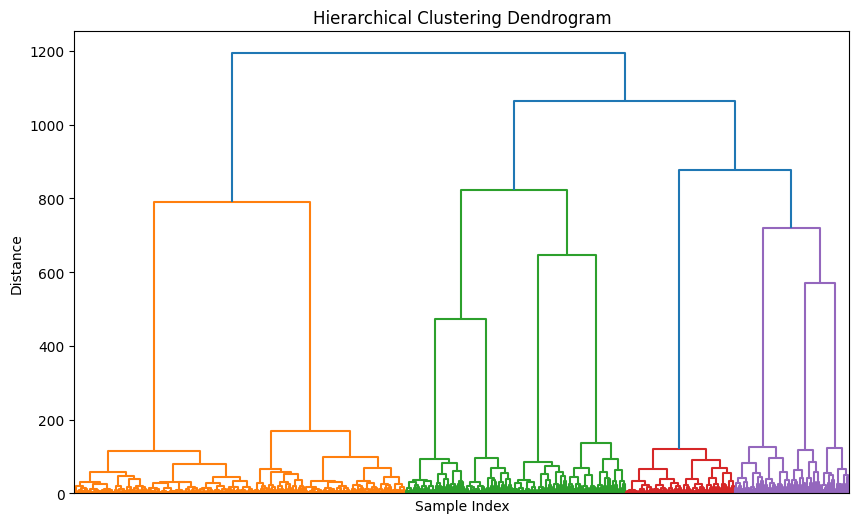

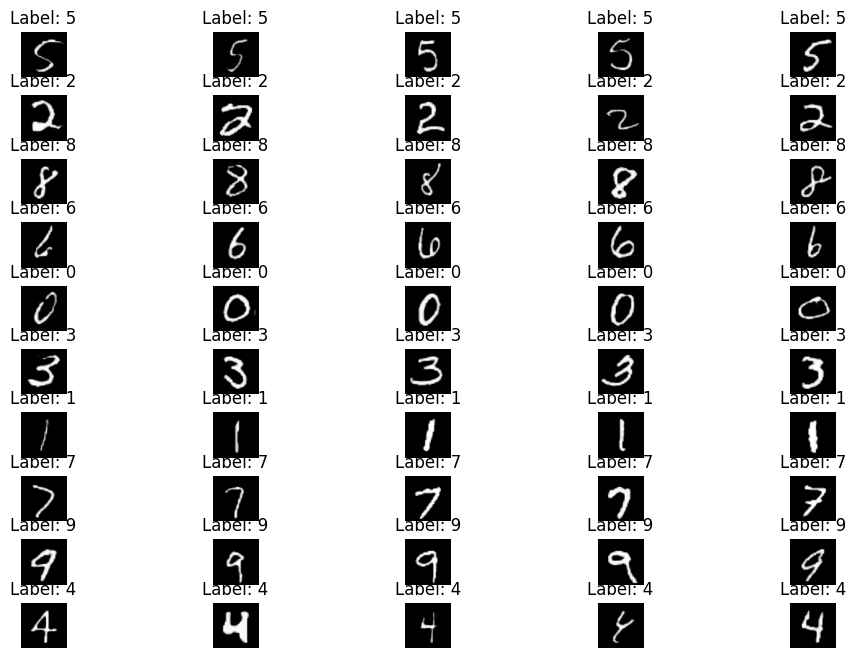

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Create a hierarchical clustering object
hierarchical = AgglomerativeClustering(n_clusters=num_classes)

# Fit the embeddings to the hierarchical clustering model
hierarchical.fit(embeddings.cpu().numpy())

# Get the predicted cluster labels
predicted_labels = hierarchical.labels_

# Compute the linkage matrix for the hierarchical clustering
linkage_matrix = linkage(embeddings.cpu().numpy(), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=num_classes, color_threshold=None, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Select a subset of images to display per cluster
subset_size = 5  # Number of images to display per cluster

# Create a figure to display the images
fig, axes = plt.subplots(num_classes, subset_size, figsize=(12, 8))

# Iterate over each cluster
for cluster_label in range(num_classes):
    cluster_indices = np.where(predicted_labels == cluster_label)[0]
    selected_indices = np.random.choice(cluster_indices, size=subset_size, replace=False)

    # Iterate over the selected indices and display the images
    for i, idx in enumerate(selected_indices):
        image = test_dataset[idx][0]  # Get the image tensor
        label = test_dataset[idx][1]  # Get the true label

        # Convert the image tensor to a NumPy array
        image = image.permute(1, 2, 0).numpy()

        # Plot the image
        axes[cluster_label, i].imshow(image, cmap='gray')
        axes[cluster_label, i].axis('off')
        axes[cluster_label, i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the figure
plt.show()

Success!

If we could do it with MNIST, we should be able to do it with our plankton images.

However, to follow this approach we will indeed need a human-labeled set of fine-tune training data to feed in. Maybe 1,000 to start?

Looking forward to your feedback!